# TransposonRead_Profile_Plot.py

## Introduction
Transposons are inserted at (more or less) random locations in the genome.
When a transposon is inserted in a gene, this gene can not be synthesized in a functional protein. Hence an insertion in a gene acts as a deletion of the protein.
Transposons are inserted in many cells (enough to have, on average, at least one transposon insertion in each location in the genome) and after insertion, these cells are given the opportunity to grow.
When a transposon is inserted in a gene that is essential for growth or multiplication, then these cells will not grow and divide and after some generations, these cells will not contribute to the population.
When the DNA of all cells in the population are sequenced (more specifically, a part of DNA near where the transposon has been inserted), the essential genes will be missing from the sequencing results (since these cells are not present in the population).
Therefore, large gaps in the transposon insertion profile might indicate the presence of essential genomic regions.

Two main factors are considered in the two plots discussed below. The number of transposon insertions in the different chromosomes and the amount of sequencing reads in each insertion. 

There are, however, some situations that might cause little transposon insertions in the non essential regions as well and also some essential regions might have transposon insertions. These are discussed in more detail in the papers by Michel et.al. 2017 and Segal et.al. 2018.

## The python script for the transposons profile plot
This function creates a bar plot with the number of transposons in a chromosome. The background of the bar plot has colored regions that indicate the locations of the genes. Green regions indicate annotated essential genes and red regions are the genes not annotated as essential. The names of the essential genes are given as well.

This graph can be used to check how well the transposon data corresponds with the location of essential genes, where only few transposon insertions are expected.

### Input
The function inputs the path to a bed file (`bed_file`, type=string) which is created by the Matlab code provided from the Kornman lab [https://sites.google.com/site/satayusers/complete-protocol/bioinformatics-analysis/matlab-script].
Next it inputs the chromosome number given as a roman numeral (`chrom`, type=string, default='I') and the bar width that indicates the width of the final bar plot (`bar_width`, type=int, default=chromosome length divided by 500). The latter two are not required as input and the `bar_width` variable takes as default value the length of the chromosome and divides this 500 bins or equal length.

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.insert(1,r'C:\Users\gregoryvanbeek\Documents\GitHub\LaanLab-SATAY-DataAnalysis\python_modules')
from chromosome_and_gene_positions import chromosome_position, chromosomename_roman_to_arabic, gene_position
from essential_genes_names import list_known_essentials
from gene_names import gene_aliases
from chromosome_names_in_files import chromosome_props_bedfile

chrom='VI'
bar_width=None
bed_file=r"X:\tnw\BN\LL\Shared\Gregory\Sequence_Alignment_TestData\Michel2017_WT1_SeqData\Cerevisiae_WT1_Michel2017_ProcessedByBenoit\E-MTAB-4885.WT1.bam.bed"

### Loading files
Next additional files are loaded. Change these to your local paths leading to the gff-file (for example downloaded from SGD [https://www.yeastgenome.org/] or get a copy from the docs folder on Github [https://github.com/Gregory94/LaanLab-SATAY-DataAnalysis]) and yeast_protein_Names file.
Also two lists of essential genes are loaded. Some essential genes are present only in a single file, hence both files are used simultenously.

In [2]:
gff_file = r"X:\tnw\BN\LL\Shared\Gregory\Gene_Database\Saccharomyces_cerevisiae.R64-1-1.99.gff3"
essential_genes_files = [r'X:\tnw\BN\LL\Shared\Gregory\Gene_Database\Cervisiae_EssentialGenes_List_1.txt',
                        r'X:\tnw\BN\LL\Shared\Gregory\Gene_Database\Cervisiae_EssentialGenes_List_2.txt']
gene_information_file = r'X:\tnw\BN\LL\Shared\Gregory\Gene_Database\Yeast_Protein_Names.txt'

### Get genes in chromosome
Determine the start and end position of the chromosome and sets the bar width if this is not input in the function by the user.

Secondly, all the genes are stored in the `gene_pos_dict` variable in the form of a list. This lsit contains the chromosome the gene is, its start and end position and the reading orientation. A for-loop is performed over all genes and only those in the chromosome of interest are saved.
Finally all known aliases of the genes are stored to make sure that most genes can be found later in the code.

In [3]:
chr_length_dict, chr_start_pos_dict, chr_end_pos_dict = chromosome_position(gff_file)

print('Chromosome length: ',chr_length_dict.get(chrom))
if bar_width == None:
    bar_width = int(chr_length_dict.get(chrom)/500)

gene_pos_dict = gene_position(gff_file)
genes_currentchrom_pos_list = [k for k, v in gene_pos_dict.items() if chrom in v]
genes_essential_list = list_known_essentials(essential_genes_files)
gene_alias_list = gene_aliases(gene_information_file)[0]

Chromosome length:  270161
Reading file : X:\tnw\BN\LL\Shared\Gregory\Gene_Database\Cervisiae_EssentialGenes_List_1.txt
Reading file : X:\tnw\BN\LL\Shared\Gregory\Gene_Database\Cervisiae_EssentialGenes_List_2.txt


### read bed file

Read the bed file and the lines that represents the chromosome of interest.

Next loop over the bed file and get all the transposon insertion locations.
For this a list is created filled with zeros with length of the chromosome. The location where a transposons has been inserted is added by one. This also accounts when there are multiple insertions at the same location.

In [4]:
with open(bed_file) as f:
    lines = f.readlines()

chrom_start_index_dict, chrom_end_index_dict= chromosome_props_bedfile(lines)[1:3]

alltransposoncounts_list = np.zeros(chr_length_dict.get(chrom))
for line in lines[chrom_start_index_dict.get(chrom):chrom_end_index_dict.get(chrom)+1]:
    line = line.strip('\n').split()
    alltransposoncounts_list[int(line[1])] += 1

### Binning
To speed up the plotting process, the data is put in bins of length determined before or as indicated by the user.

In [5]:
alltransposoncounts_binnedlist = []
val_counter = 0
sum_values = 0
if bar_width == 1:
    alltransposoncounts_binnedlist = alltransposoncounts_list
    allinsertionsites_list = np.linspace(0,chr_length_dict.get(chrom),int(chr_length_dict.get(chrom)/float(bar_width)))
else:
    for n in range(len(alltransposoncounts_list)):
        if val_counter % bar_width != 0:
            sum_values += alltransposoncounts_list[n]
        elif val_counter % bar_width == 0:
            alltransposoncounts_binnedlist.append(sum_values)
            sum_values = 0
        val_counter += 1
        
    allinsertionsites_list = np.linspace(0,chr_length_dict.get(chrom),int(chr_length_dict.get(chrom)/bar_width)+1)

### Plotting

Plotting chromosome  VI ...
bar width for plotting is  540


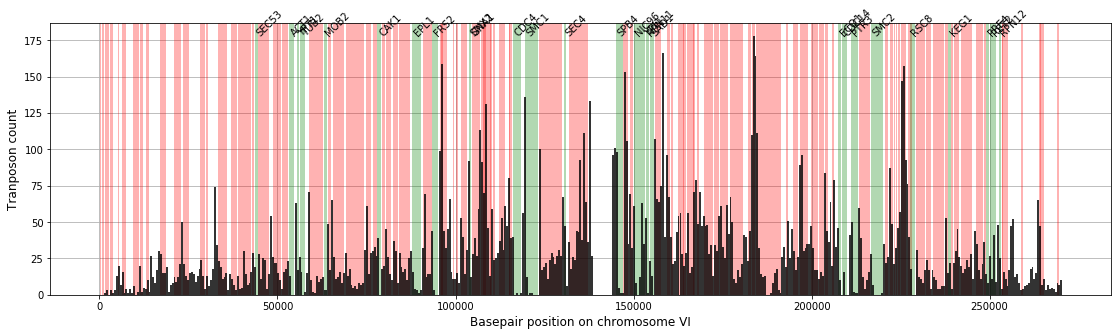

In [13]:
print('Plotting chromosome ', chrom, '...')
print('bar width for plotting is ',bar_width)
binsize = bar_width

#fig,ax = plt.subplots()
plt.figure(figsize=(19,5))#(figsize=(19,9))
grid = plt.GridSpec(1, 1, wspace=0.4, hspace=0.3)

ax = plt.subplot(grid[0,0])
for gene in genes_currentchrom_pos_list:
    gene_start_pos = int(gene_pos_dict.get(gene)[1])
    gene_end_pos = int(gene_pos_dict.get(gene)[2])
    if gene in genes_essential_list:
        ax.axvspan(gene_start_pos,gene_end_pos,facecolor='g',alpha=0.3)
        ax.text(gene_start_pos,max(alltransposoncounts_binnedlist),gene_alias_list.get(gene)[0], rotation=45)
    else:
        ax.axvspan(gene_start_pos,gene_end_pos,facecolor='r',alpha=0.3)
ax.bar(allinsertionsites_list,alltransposoncounts_binnedlist,width=binsize,color=(0.0,0.0,0.0,0.8))
#    ax.set_yscale('log')
ax.set_axisbelow(True)
ax.grid(True)
ax.set_xlabel('Basepair position on chromosome '+chrom, fontsize=12)
ax.set_ylabel('Tranposon count', fontsize=12)
#    ax.set_title('Transposon profile for chromosome '+chrom)
plt.show()

## Bibliography
- Michel, A. H., Hatakeyama, R., Kimmig, P., Arter, M., Peter, M., Matos, J., ... & Kornmann, B. (2017). Functional mapping of yeast genomes by saturated transposition. Elife, 6, e23570.
- Segal, E. S., Gritsenko, V., Levitan, A., Yadav, B., Dror, N., Steenwyk, J. L., ... & Kunze, R. (2018). Gene essentiality analyzed by in vivo transposon mutagenesis and machine learning in a stable haploid isolate of Candida albicans. MBio, 9(5), e02048-18.